# Explore Dual-Pol Data from SAIL
Look at the dual-pol fields from the Xband radar, investigating the differential phase and calculating the specific differential phase.

## Imports

In [85]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import fiona
import geopandas as gpd
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default


## Read the East River Watershed File

In [86]:
east_river = gpd.read_file('data/site-locations/East_River.kml')

## Read in a date

In [195]:
hour = '19'
day = '25'
month = '08'
year = '2022'

files = sorted(glob.glob(f'/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/{year}{month}_glued/xprecipradar_guc_volume_{year}{month}{day}-{hour}*'))

In [196]:
radar = pyart.io.read(files[-1])

(-20.0, 20.0)

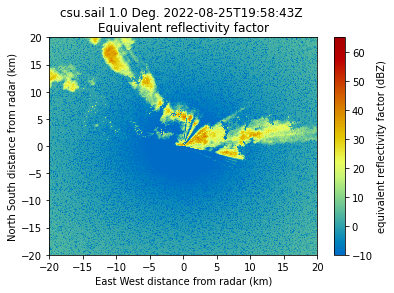

In [197]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

## Calculate Velocity Texture

In [198]:
nyquist_value = radar.fields['VEL']['data'].max()
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='VEL',
                                                        nyq=nyquist_value)

radar.add_field('velocity_texture', vel_texture, replace_existing=True)

/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/pyart/retrieve/simple_moment_calculations.py:298: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  vel_texture_field['data'] = ndimage.filters.median_filter(vel_texture,


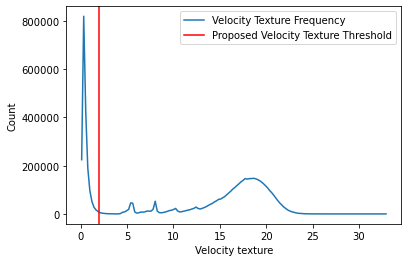

In [199]:
hist, bins = np.histogram(radar.fields['velocity_texture']['data'],
                          bins=150)
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='Velocity Texture Frequency')
plt.axvline(2,
            color='r',
            label='Proposed Velocity Texture Threshold')

plt.xlabel('Velocity texture')
plt.ylabel('Count')
plt.legend()

In [200]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('velocity_texture', 3)

(-20.0, 20.0)

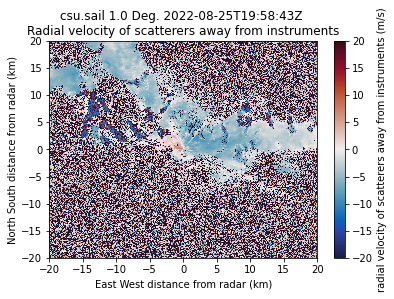

In [201]:
display = pyart.graph.RadarDisplay(radar)
display.plot('VEL', vmin=-20, vmax=20, cmap='pyart_balance')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

## Visualize the velocity field

(-20.0, 20.0)

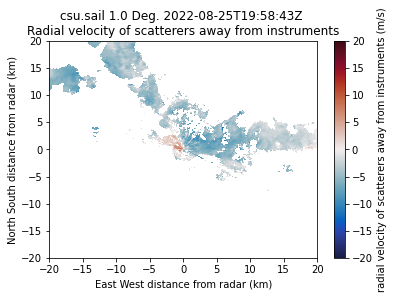

In [202]:
display = pyart.graph.RadarDisplay(radar)
display.plot('VEL', gatefilter=gatefilter, vmin=-20, vmax=20, cmap='pyart_balance')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

## Apply Differential Phase Texture

In [203]:
phidp_texture = pyart.retrieve.texture_of_complex_phase(radar, phidp_field='PHIDP', phidp_texture_field='phidp_texture')

phidp_texture
radar.add_field('phidp_texture', phidp_texture, replace_existing=True)

(-30.0, 30.0)

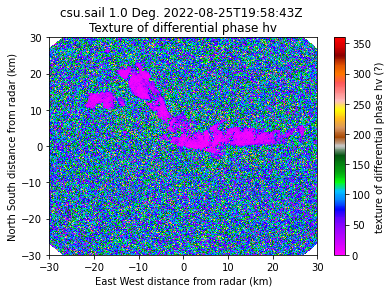

In [204]:
display = pyart.graph.RadarDisplay(radar)
display.plot('phidp_texture', cmap='pyart_Wild25', vmin=0, vmax=360)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

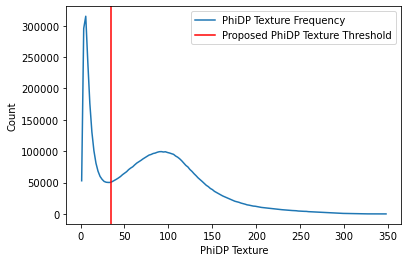

In [205]:
hist, bins = np.histogram(radar.fields['phidp_texture']['data'],
                          bins=150)
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='PhiDP Texture Frequency')
plt.axvline(35,
            color='r',
            label='Proposed PhiDP Texture Threshold')

plt.xlabel('PhiDP Texture')
plt.ylabel('Count')
plt.legend()

(-30.0, 30.0)

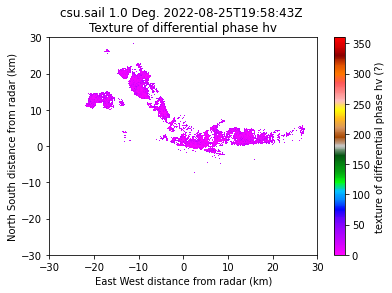

In [206]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('phidp_texture', 30)
gatefilter.exclude_above('velocity_texture', 10)

display = pyart.graph.RadarDisplay(radar)
display.plot('phidp_texture', gatefilter=gatefilter, cmap='pyart_Wild25', vmin=0, vmax=360)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## Calculate Specific Differential Phase (KDP)

In [208]:
def kdp(radar, refl_field='DBZ', psidp_field='PHIDP', gatefilter=None, method=None):
    """
    Computes KDP using given method and attach it to a pyart.Radar object.

    """
    if method is None:
        sys.exit(" Choose method: 'maesaka', 'schneebeli', 'vulpiani' ")
    elif method == 'maesaka':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, gatefilter=gatefilter, refl_field=refl_field, psidp_field=psidp_field)
    elif method == 'schneebeli':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_schneebeli(radar, gatefilter=gatefilter, psidp_field=psidp_field)
    elif method == 'vulpiani':
        kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_vulpiani(radar, gatefilter=gatefilter, psidp_field=psidp_field, band='X')
    else:
        sys.exit(" Wrong method name. Choose method: 'maesaka', 'schneebeli', 'vulpiani' ")
    kdp_field_name = 'kdp_' + method
    
    radar.fields[kdp_field_name]=kdp
    return radar

In [209]:
radar = kdp(radar, gatefilter=gatefilter, method='maesaka')

/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(-30.0, 30.0)

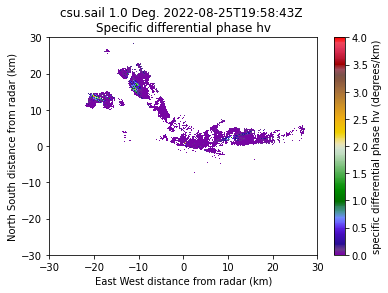

In [215]:
display = pyart.graph.RadarDisplay(radar)
display.plot('kdp_maesaka', gatefilter=gatefilter, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-30, 30)
plt.ylim(-30, 30)

(-10.0, 10.0)

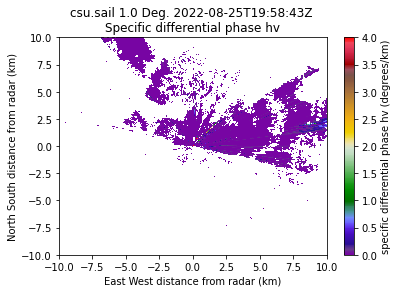

In [216]:
display = pyart.graph.RadarDisplay(radar)
display.plot('kdp_maesaka', gatefilter=gatefilter, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

(-10.0, 10.0)

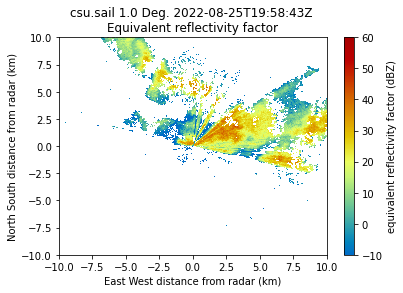

In [217]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ', gatefilter=gatefilter, vmin=-10, vmax=60, cmap='pyart_HomeyerRainbow',)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are de

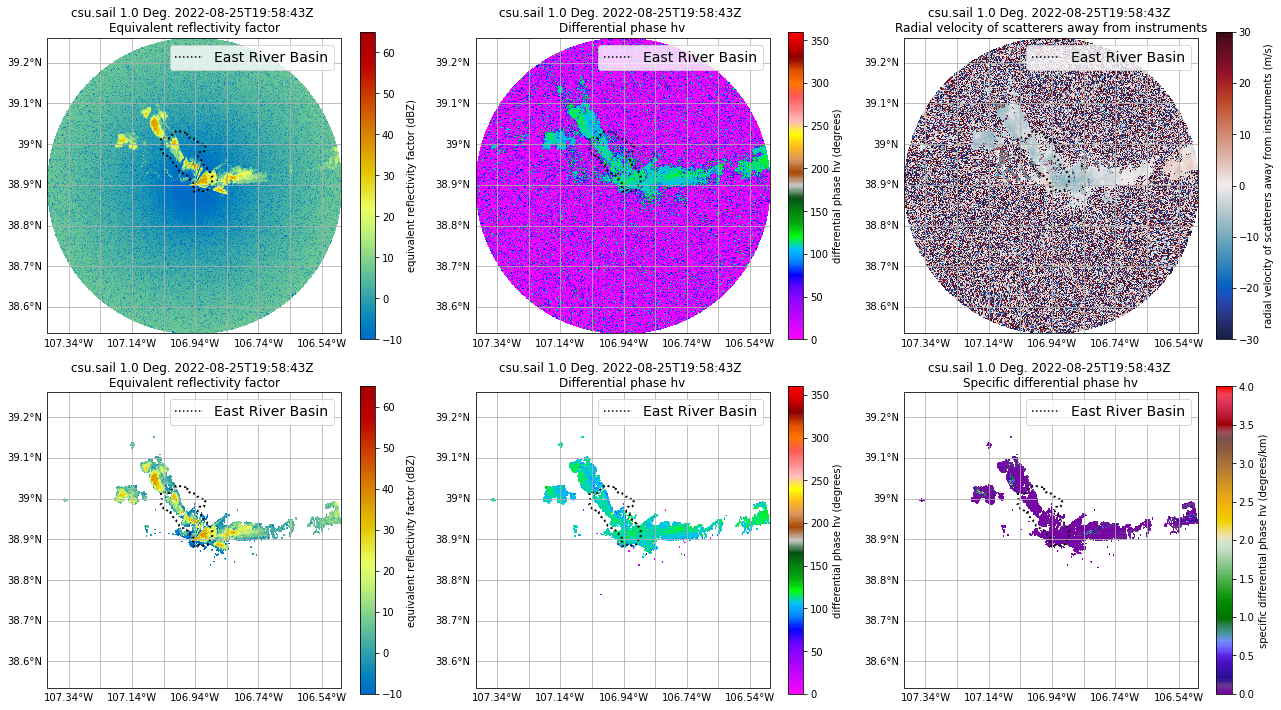

In [218]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(18,10))

# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 2)
lon_center = round(radar.longitude['data'][0], 2)

# Set the projection - in this case, we use a general PlateCarree projection
projection = ccrs.PlateCarree()

# Determine the ticks
lat_ticks = np.arange(lat_center-2, lat_center+2, .1)
lon_ticks = np.arange(lon_center-2, lon_center+2, .1)

ax1 = plt.subplot(231, projection=projection)
display.plot_ppi_map("DBZ", 0, resolution='10m', ax=ax1, lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax1,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax1.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)


ax2 = plt.subplot(232,projection=projection)
display.plot_ppi_map("PHIDP", 0, resolution='10m', cmap='pyart_Wild25', ax=ax2, vmin=0, vmax=360, lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax2,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax2.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)

ax3 = plt.subplot(233,projection=projection)
display.plot_ppi_map("VEL", 0, resolution='10m', ax=ax3, vmin=-30, vmax=30, cmap='pyart_balance', lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax3,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax3.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)

ax4 = plt.subplot(234, projection=projection)
display.plot_ppi_map("DBZ", 0, gatefilter=gatefilter, resolution='10m', ax=ax4, lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax4,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax4.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)


ax5 = plt.subplot(235, projection=projection)
display.plot_ppi_map("PHIDP", 0, gatefilter=gatefilter, resolution='10m', ax=ax5, vmin=0, vmax=360, cmap='pyart_Wild25', lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax5,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax5.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)

ax6 = plt.subplot(236,projection=projection)
display.plot_ppi_map("kdp_maesaka", 0, gatefilter=gatefilter, resolution='10m', ax=ax6, vmin=0, vmax=4, cmap='pyart_Carbone42', lat_lines=lat_ticks, lon_lines=lon_ticks)
east_river.plot(ax=ax6,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)
ax6.plot(lon_center,
         lat_center,
         color='k',
         linestyle=':',
         label='East River Basin')
plt.legend(loc='upper right',
           fontsize=14)

plt.tight_layout()
plt.savefig('phidp_kdp_comparison_sail.png', dpi=300, transparent=False)